# This notebook presents a Brain tumor segmentation using the pre-trained model MaskRcnn to detect and segment the tumor in the brain

# 1.load the data from Roboflow

In [160]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="OnGlMCYxYZ8dDgjdDCKf")
project = rf.workspace("ons").project("brain-fkcpf")
dataset = project.version(1).download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Brain-1 in coco:: 100%|██████████| 46/46 [00:00<00:00, 2905.30it/s]


In [161]:
#install the ncessary package
!pip install pycocotools
!pip install gdown

In [2]:
#import the necessary packages
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
import torchvision
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import torch
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

device: cpu


# 2.Test the pre-trained model before the fine tuning

In [4]:
# version dependent: pretrained=True or weights='DEFAULT' (newer, there are many pretrained weights)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
# Change to use-only mode for lower memory requirements and faster operation.
model.eval().to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 94.9MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
# Download an tumor brain image from  for internet%
torch.hub.download_url_to_file('https://wikiwandv2-19431.kxcdn.com/_next/image?url=https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg&w=640&q=50', 'tumor.jpg')

100%|██████████| 14.0k/14.0k [00:00<00:00, 29.9MB/s]


In [ ]:
def prediction(model, image_path, threshold=0.25):
    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # Move the tensor to the specified device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    img = img.to(device)

    # Model inference
    with torch.no_grad():
        pred = model([img[0]])

    # Load the original image
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Convert the mask to a numpy array
    mask_np = np.squeeze(pred[0]['masks'].detach().cpu().numpy()[0, :, :], axis=0)

    # Resize the mask to match the size of the original image
    mask_np_resized = cv2.resize(mask_np, (original_img.shape[1], original_img.shape[0]))

    # Threshold the mask to get a binary mask
    binary_mask = (mask_np_resized > threshold).astype(np.uint8)

    # Overlay the mask on the original image
    result_img = original_img.copy()
    result_img[binary_mask == 1, :] = [0, 255, 0]  # Green color for the mask

    # Assuming pred[0]['boxes'] is a tensor with bounding box coordinates
    # Assuming pred[0]['labels'] is a tensor with class labels
    boxes = pred[0]['boxes'].detach().cpu().numpy()
    labels = pred[0]['labels'].detach().cpu().numpy()
    masks = pred[0]['masks'].detach().cpu().numpy()

    # Display the original image with bounding boxes, class names, and the overlay
    plt.figure(figsize=(15, 20))

    plt.subplot(1, 2, 1)
    plt.imshow(result_img)
    plt.title('Image with Mask Overlay')

    ax = plt.gca()

    for box, label, mask in zip(boxes, labels, masks):
        # Display bounding boxes
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        # Display class names

        plt.text(x, y, CLASS_NAMES[label], color='b', verticalalignment='top')

    plt.subplot(1, 2, 2)
    plt.imshow(original_img)
    plt.title('Original Image')

    plt.show()


**Based on the pre-trained model's prediction results, MaskRcnn was unable to segment the tumor and instead detect other classes. Fine-tuning the pre-trained model is necessary to  segment correctly  the tumor in the brain.**

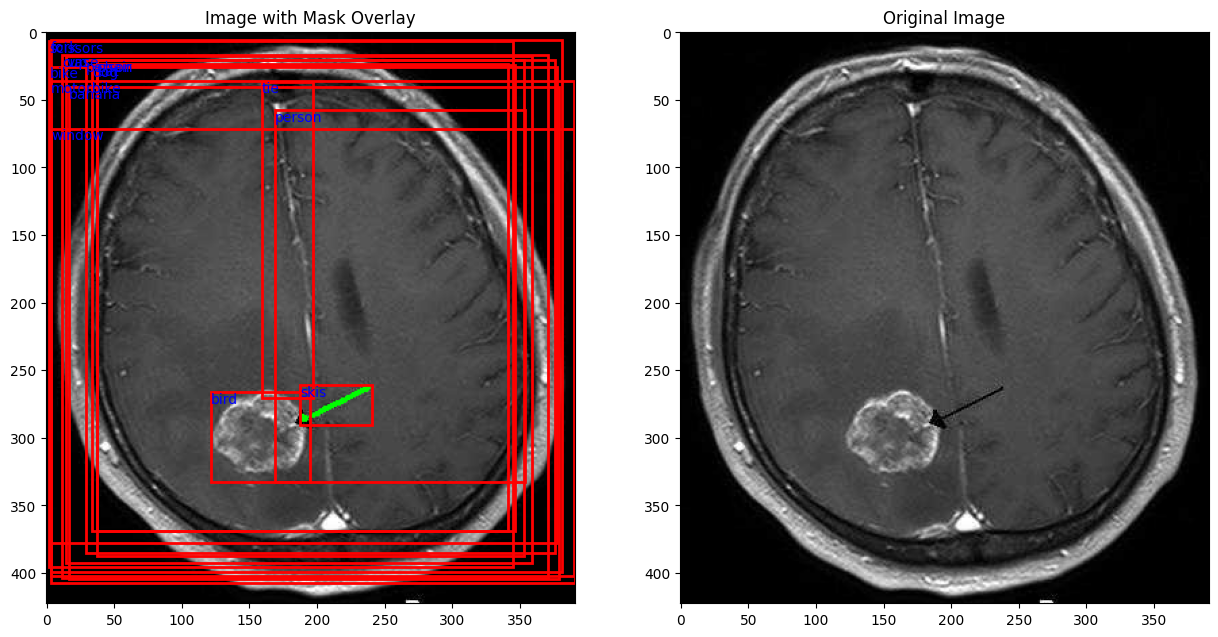

In [15]:


CLASS_NAMES = ['background', 'person', 'bike', 'auto', 'motorbike', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'hydrant' , 'sign', 'stop sign', 'parking clock', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', ' zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoes', 'glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard' , 'sports ball', 'flying kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hotdog', 'pizza', 'doughnut', 'cake', 'chair ', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'table', 'toilet', 'door', 'tv', 'laptop', 'mouse' , 'remote control', 'keyboard', 'mobile phone', 'microwave oven', 'oven', 'toaster', 'dishwasher', 'refrigerator', 'smoothie', 'book', 'clock', 'vase' , 'scissors', 'teddy bear', 'hair dryer', 'toothbrush', 'comb']

prediction(model, '/content/tumor.jpg', threshold=0.5)


# 3.Fine-tuning **Mask R-CNN** on Brain Tumor dataset

***3.1.Data Preparation:***
Class CCDataset is the custom dataset class for training and validation using the COCO dataset format. The dataset contains images along with corresponding annotations for object detection. This class generates from data  the dictionary :
"boxes": Bounding boxes of objects in the image.
"labels": Class labels (assumed to be 1 for all objects).
"masks": Binary masks for objects in the image.

In [193]:
#prepare data
TRAIN_DIR ='/content/Brain-1/train'
VALID_DIR = '/content/Brain-1/valid'
class CCDataset(Dataset):
  def __init__(self, mode = 'train', augmentation=None):
    if mode == 'train':
      self.dataset_path = TRAIN_DIR
      ann_path = os.path.join(TRAIN_DIR, '_annotations.coco.json')
    if mode == 'valid':
      self.dataset_path = VALID_DIR
      ann_path = os.path.join(VALID_DIR, '_annotations.coco.json')


    self.coco = COCO(ann_path)
    self.image_ids= self.coco.getImgIds()
    self.augmentation=augmentation

  def __len__(self):
      return len(self.coco.imgs)

  def get_masks(self, index):
      ann_ids = self.coco.getAnnIds([index])
      anns = self.coco.loadAnns(ann_ids)
      masks=[]

      for ann in anns:
            mask = self.coco.annToMask(ann)
            masks.append(mask)

      return masks

  def get_boxes(self, masks):
      num_objs = len(masks)
      boxes = []

      for i in range(num_objs):
          x,y,w,h = cv2.boundingRect(masks[i])
          boxes.append([x, y, x+w, y+h])

      return np.array(boxes)

  def __getitem__(self, index):
      # Load image
      img_info = self.coco.loadImgs([index])[0]
      image = cv2.imread(os.path.join(self.dataset_path,
                                    img_info['file_name']))
      masks = self.get_masks(index)

      if self.augmentation:
        augmented = self.augmentation(image=image, masks=masks)
        image, masks = augmented['image'], augmented['masks']

      image = image.transpose(2,0,1) / 255.

      # Load masks
      masks = np.array(masks)
      boxes = self.get_boxes(masks)

      # Create target dict6
      num_objs = len(masks)
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.ones((num_objs,), dtype=torch.int64)
      masks = torch.as_tensor(masks, dtype=torch.uint8)
      image = torch.as_tensor(image, dtype=torch.float32)
      data = {}
      data["boxes"] =  boxes
      data["labels"] = labels
      data["masks"] = masks

      return image, data

In [194]:
# To bypass shape errors
# Images contain different number of instances
def collate_fn(batch):
  images = list()
  targets = list()
  for b in batch:
        images.append(b[0])
        targets.append(b[1])
  images = torch.stack(images, dim=0)
  return images, targets

In [195]:
#transformation/
transform = A.Compose([
    A.HorizontalFlip(p=0.5)

])

# **Fine Tuning MaskRcnn:**
We take a pre-trained Mask R-CNN model and fine-tune it for a specific instance segmentation task, which may involve a different number of classes (num_classes). The process first extracts the number of input features for the classifier head (in_features) of the original model. Then, it replaces the pre-trained box predictor head with a new one (FastRCNNPredictor) that is customized for the target task, with the specified number of output classes (num_classes).

In [196]:
# load an instance segmentation model pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)


In [198]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [215]:
#define optimizer

optimizer = torch.optim.AdamW(params=model.parameters(),lr=0.0005)
lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

In [200]:

train_dataset = CCDataset(mode='train', augmentation=transform)
train_loader = DataLoader(dataset=train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=2,
                              collate_fn=collate_fn)

valid_dataset = CCDataset(mode='valid')
valid_loader = DataLoader(dataset=valid_dataset,
                              batch_size=8,
                              shuffle=False,
                              collate_fn=collate_fn)
len_dataset = len(train_dataset)
len_valid = len(valid_dataset)
len_train=len(train_dataset)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Show some examples of data

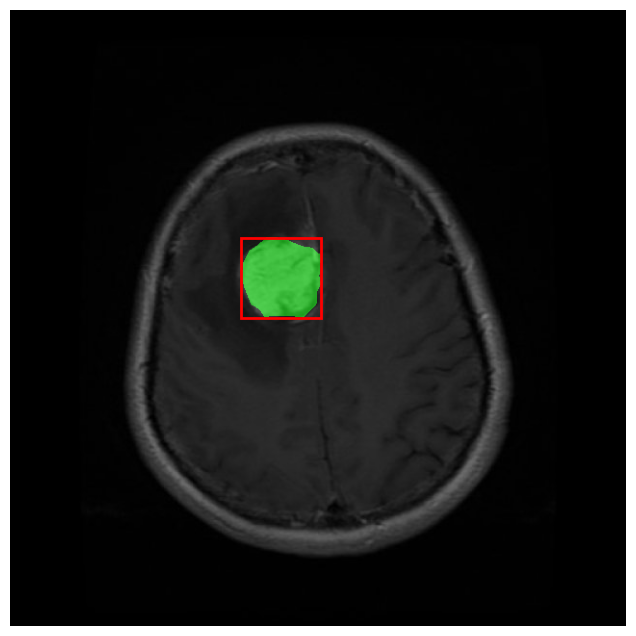

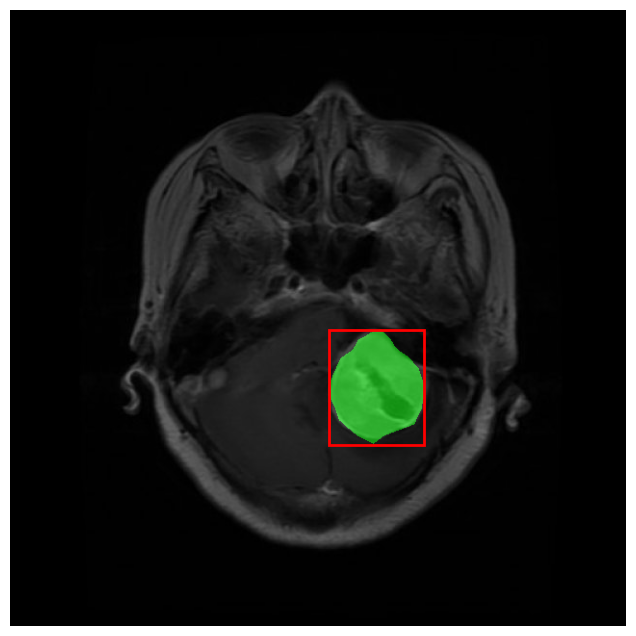

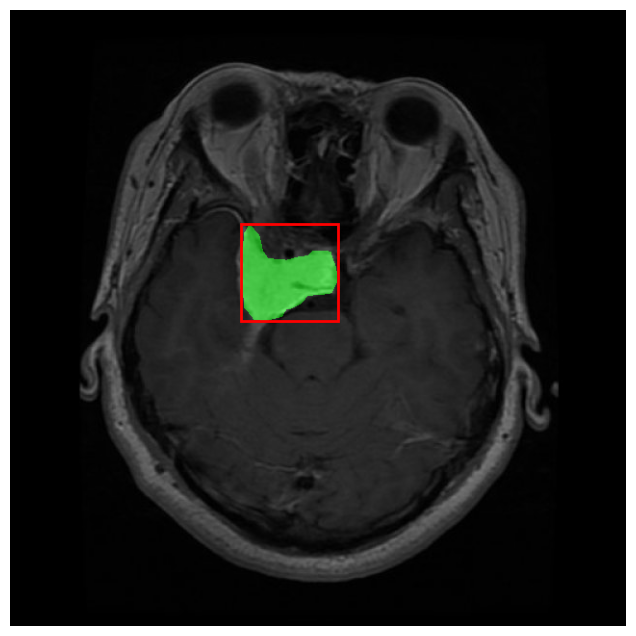

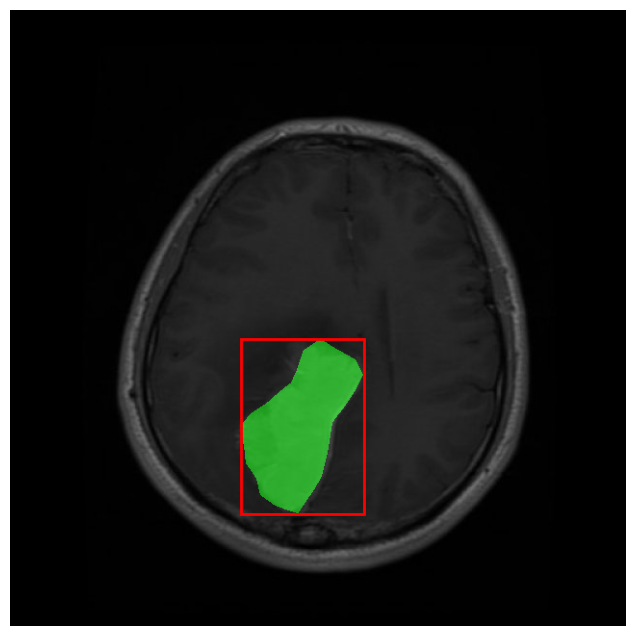

In [229]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image
from PIL import Image

# Assuming you have already loaded the train_loader from the previous code snippet

# Get a batch from the training loader
for images, targets in train_loader:
    # Assuming there are two images in the batch for visualization
    for i in range(1):
        image = images[i]
        target = targets[i]

        # Convert tensor masks to numpy arrays for visualization
        masks = target['masks'].numpy()

        # Visualize the image
        plt.figure(figsize=(8, 8))
        plt.imshow(to_pil_image(image))

        # Visualize each colored mask on the image
        for mask in masks:
            mask = mask.squeeze()  # Remove singleton dimension
            colored_mask = Image.fromarray(mask)

            # Apply the color palette
            colored_mask.putpalette([
                0, 0, 0,  # index 0 is black for the background
                0,255, 0,  # index 1 is red
                255, 255, 0,  # index 2 is yellow
                255, 153, 0,  # index 3 is orange
            ])

            plt.imshow(colored_mask, alpha=0.5)

        # Visualize bounding boxes
        for box in target['boxes']:
            x, y, w, h = box.numpy()
            rect = patches.Rectangle((x, y), w-x, h-y, linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)

        plt.axis('off')
        plt.show()


# Loss Function

In [202]:
train_loss_dict_t = {}
train_loss_dict_t['loss_classifier']=0
train_loss_dict_t['loss_box_reg']=0
train_loss_dict_t['loss_objectness']=0
train_loss_dict_t['loss_rpn_box_reg']=0


** Traning and valid the model**
In this training process i apply the early stop method based on the best_loss.best_loss: Initialize a variable to store the best validation loss encountered during training. .

In [203]:
# number of epochs
num_epochs = 50
batch_size=8
hist_train_classifier=[]
hist_valid_classifier=[]
hist_train_box_reg=[]
hist_valid_box_reg=[]
hist_train_objectness=[]
hist_valid_objectness=[]
hist_train_rpn_box_reg=[]
hist_valid_rpn_box_reg=[]

best_loss=float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_tolerant_count=0
early_stop_tolerant=10;
model.train()
for epoch in range(num_epochs):

    train_loss_dict_t = {}
    train_loss_dict_t['loss_classifier']=0
    train_loss_dict_t['loss_box_reg']=0
    train_loss_dict_t['loss_objectness']=0
    train_loss_dict_t['loss_rpn_box_reg']=0
    train_losses_t=0
    for images, targets in train_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        train_loss_dict = model(images, targets)
        print(train_loss_dict)

        train_losses = sum(loss for loss in train_loss_dict.values())
        train_loss_dict_t={x: train_loss_dict_t.get(x, 0) + train_loss_dict.get(x, 0)/len_train*batch_size  for x in set(train_loss_dict)}
        train_losses_t=train_losses_t+train_losses
        optimizer.zero_grad()
        train_losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    # Validation
    with torch.no_grad():
      valid_loss_dict_t = {}
      valid_loss_dict_t['loss_classifier']=0
      valid_loss_dict_t['loss_box_reg']=0
      valid_loss_dict_t['loss_objectness']=0
      valid_loss_dict_t['loss_rpn_box_reg']=0
      valid_losses_t=0
      for images, targets in valid_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        valid_loss_dict = model(images, targets)
        valid_losses = sum(loss for loss in valid_loss_dict.values())
        valid_loss_dict_t={x: valid_loss_dict_t.get(x, 0) + valid_loss_dict.get(x, 0)/len_valid*batch_size  for x in set(valid_loss_dict)}
        valid_losses_t=valid_losses_t+valid_losses
      valid_losses0=valid_losses/len_valid*batch_size
      hist_train_classifier.append(np.array(train_loss_dict_t['loss_classifier'].cpu().detach()))
      hist_valid_classifier.append(np.array(valid_loss_dict_t['loss_classifier'].cpu().detach()))
      hist_train_box_reg.append(np.array(train_loss_dict_t['loss_box_reg'].cpu().detach()))
      hist_valid_box_reg.append(np.array(valid_loss_dict_t['loss_box_reg'].cpu().detach()))
      hist_train_objectness.append(np.array(train_loss_dict_t['loss_objectness'].cpu().detach()))
      hist_valid_objectness.append(np.array(valid_loss_dict_t['loss_objectness'].cpu().detach()))
      print(hist_train_objectness)
      print(hist_valid_objectness)
      hist_train_rpn_box_reg.append(np.array(train_loss_dict_t['loss_rpn_box_reg'].cpu().detach()))
      hist_valid_rpn_box_reg.append(np.array(valid_loss_dict_t['loss_rpn_box_reg'].cpu().detach()))
      # Always save the current best model based on the validation data, and stop the training if no improvements happen after a certain epoch.
      early_stop_tolerant_count=early_stop_tolerant_count+1
      if valid_losses_t < best_loss:
        early_stop_tolerant_count=0
        best_loss = valid_losses_t
        best_model_wts = copy.deepcopy(model.state_dict())
      if early_stop_tolerant_count>=early_stop_tolerant:
        break
      if epoch % 1 != 0:
        continue
      # Display some information along the training
      print("Epoch: ", epoch, ".")
      print("Training losses: ")
      print("Classifier loss: ", format(train_loss_dict_t['loss_classifier'].item(), ".2f"))
      print("Box regression loss: ", format(train_loss_dict_t['loss_box_reg'].item(), ".2f"))
      print("Objectness loss: ", format(train_loss_dict_t['loss_objectness'].item(), ".2f"))
      print("RPN box regression loss: ", format(train_loss_dict_t['loss_rpn_box_reg'].item(), ".2f"))
      print("Validation losses: ")
      print("Classifier loss: ", format(valid_loss_dict_t['loss_classifier'].item(), ".2f"))
      print("Box regression loss: ", format(valid_loss_dict_t['loss_box_reg'].item(), ".2f"))
      print("Objectness loss: ", format(valid_loss_dict_t['loss_objectness'].item(), ".2f"))
      print("RPN box regression loss: ", format(valid_loss_dict_t['loss_rpn_box_reg'].item(), ".2f"))



{'loss_classifier': tensor(0.3598, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0941, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(2.0927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.0338, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.0604, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0408, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(2.1697, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.2070, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.0472, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0169, device

# Plots different losses


During the training of your MaskRcnn model, it is a good sign if you notice a consistent decrease in the loss values of all three components - classifier, bounding box regression, and segmentation. When the loss values decrease, it means that your model is learning and improving its ability to predict accurately on both the training and validation sets. So, decreasing loss values is a positive indicator of your model's performance.

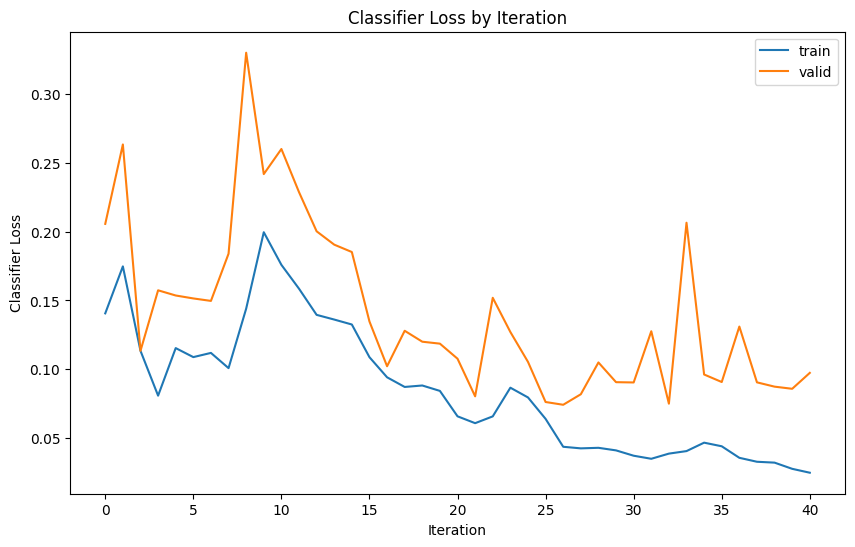

In [226]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('Classifier Loss')
plt.title('Classifier Loss by Iteration')
plt.plot(hist_train_classifier)
plt.plot(hist_valid_classifier)

plt.legend(['train', 'valid'])

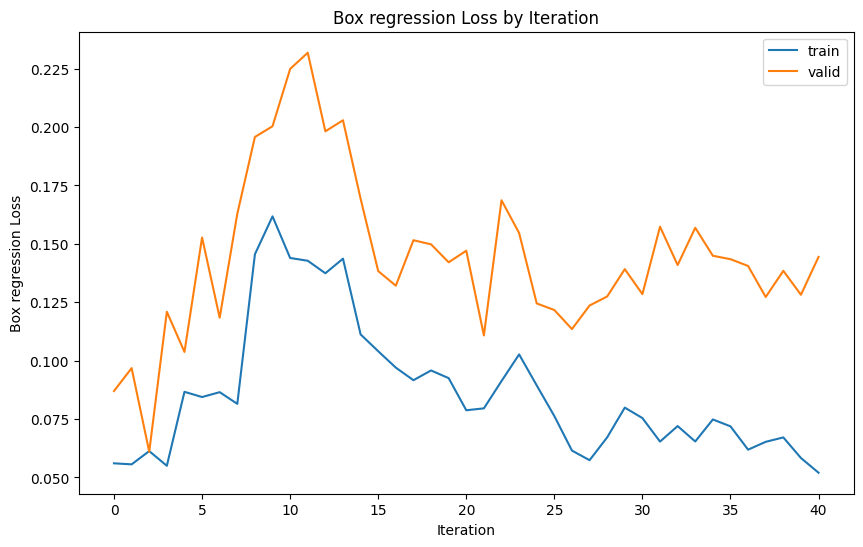

In [225]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('Box regression Loss')
plt.title('Box regression Loss by Iteration')
plt.plot(hist_train_box_reg)
plt.plot(hist_valid_box_reg)

plt.legend(['train', 'valid'])

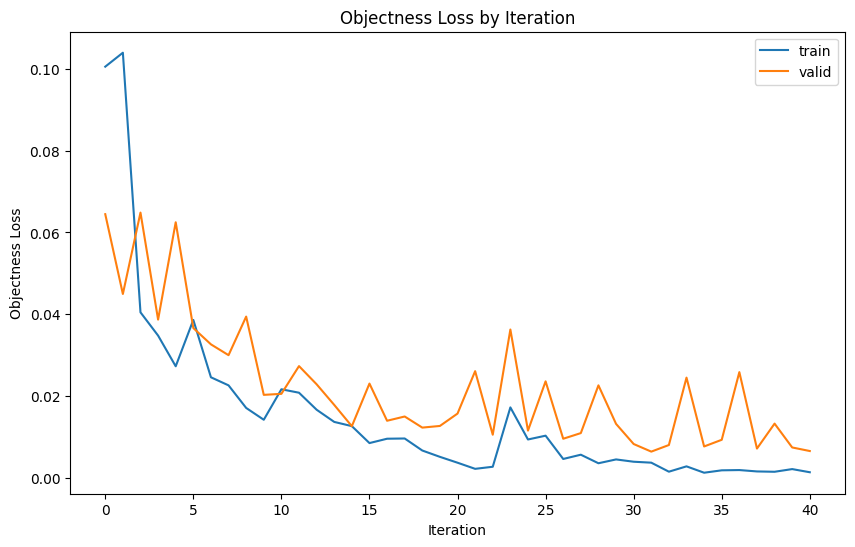

In [224]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('Objectness Loss')
plt.title('Objectness Loss by Iteration')
plt.plot(hist_train_objectness)
plt.plot(hist_valid_objectness)

plt.legend(['train', 'valid'])

# Save model

In [183]:
if os.path.isdir('maskrcnn_weights')==False: os.mkdir('maskrcnn_weights')

In [184]:
torch.save(model, 'maskrcnn_weights/mask-rcnn-brain.pt')

In [185]:
torch.save(model.state_dict(), 'maskrcnn_weights/mask-rcnn-brain_weights.pt')

# Load the saved model

In [186]:
model.load_state_dict(torch.load('/content/maskrcnn_weights/mask-rcnn-brain_weights.pt'))

<All keys matched successfully>

# Test Model on some images from internet


In [204]:
model.eval()
CLASS_NAMES = ['__background__', 'tumor']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [211]:
# Download an image from  for internet%
torch.hub.download_url_to_file('https://wikiwandv2-19431.kxcdn.com/_next/image?url=https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg&w=640&q=50', 'tumor.jpg')

100%|██████████| 14.0k/14.0k [00:00<00:00, 28.7MB/s]


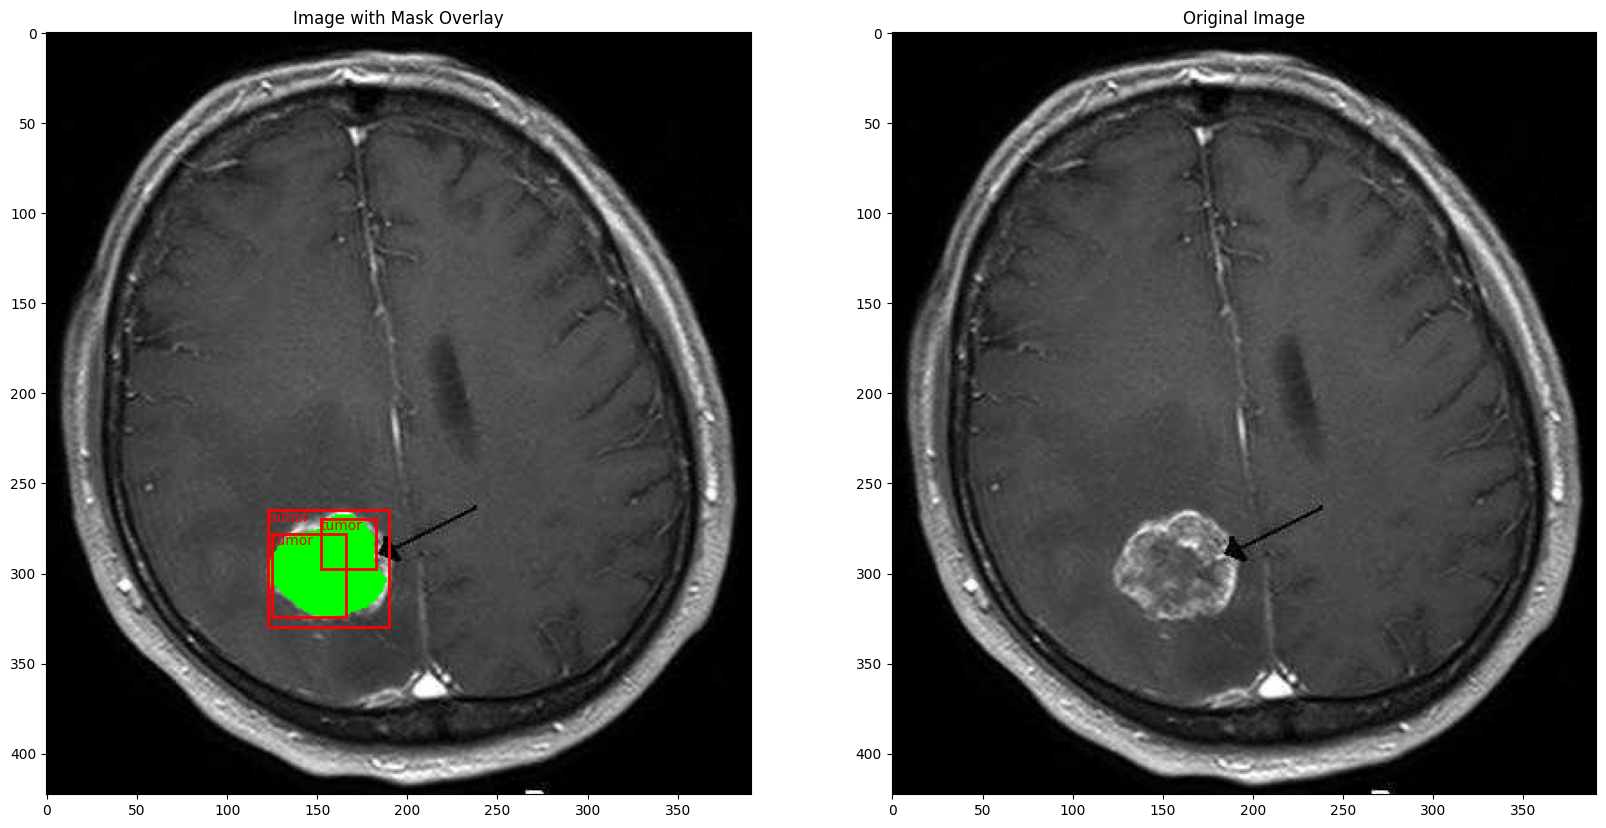

In [213]:

prediction(model, '/content/tumor.jpg', threshold=0.7)
